In this file, I construct the FC with wU directly. Let wU=$(v_1, \ldots, v_d)$, the $(i,j)$th value of FC is $$\exp(-|v_i-v_j|)$$. 


(remove the diaginal term)

In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
import bct

In [3]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm, trange
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
%matplotlib inline

In [4]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Some fns

In [5]:
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [6]:
def obt_FC(U, ws):
    """get FC 
        exp(-|v_i - v_j|)
        (remove the diaginal term)
    """
    wUAll = np.abs(np.matmul(U, np.array(ws).T).real)
    FCs = []
    for wU in wUAll.T:
        #FC = np.exp(-np.abs(wU.reshape(-1, 1) - wU.reshape(1, -1)))
        FC = np.exp(-np.abs(wU.reshape(-1, 1) - wU.reshape(1, -1))/WU_STD)
        FC = FC - np.diag(np.diag(FC))
        #FC = np.arctanh(FC)
        FCs.append(FC)
    return FCs

In [7]:
def sysMatShuffle(mat):
    mat = mat.copy()
    trlMask1 = np.tril(np.ones_like(mat), k=-1)
    eles = mat[trlMask1==1]
    np.random.shuffle(eles)
    sMat = np.zeros_like(mat)
    sMat[trlMask1==1] = eles
    diag_vs = np.diag(mat)
    np.random.shuffle(diag_vs)
    sMat = sMat + sMat.T + np.diag(diag_vs)
    return sMat

In [8]:
def NetMeasureFn(mat, nrep=50, show_prog=False):
    Cs = bct.clustering_coef_wu(mat)
    mC = np.mean(Cs)
    Ls = bct.distance_wei(mat)[0]
    mL = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
    _, Q = bct.modularity_und(mat)
    
    ranLs = []
    ranQs = []
    ranCs = []
    if show_prog:
        pbar = trange(nrep)
    else:
        pbar = range(nrep)
    for i in pbar:
        sMat = sysMatShuffle(mat)
        Cs = bct.clustering_coef_wu(sMat)
        mCi = np.mean(Cs)
        ranCs.append(mCi)
        Ls = bct.distance_wei(sMat)[0]
        mLi = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
        ranLs.append(mLi)
        _, Qi = bct.modularity_und(sMat)
        ranQs.append(Qi)
    
    tQ = Q/np.mean(ranQs)
    tmL  = mL/np.mean(ranLs)
    tmC  = mC/np.mean(ranCs)
    return {
        "tmC": tmC, 
        "tmL": tmL, 
        "tQ": tQ, 
        "mC": mC, 
        "mL": mL, 
        "Q": Q, }

In [9]:
# calculat the topk mean of graphic feature based on dwell time
def topk_mean(topk, graphic_f, dwell, key, onlyk=False):
    if onlyk:
        assert len(dwell)>= topk
        idxs = np.array([np.argsort(-dwell)[topk-1]])
    else:
        idxs = np.argsort(-dwell)[:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    sel_dwell = dwell[idxs]
    mean_v = np.mean(sel_graphic_f)
    ws = sel_dwell/np.sum(sel_dwell)
    wmean_v = np.sum(ws*sel_graphic_f)
    return mean_v, wmean_v

In [10]:
# calculat the topk mean of graphic feature based on dwell time after removing top1 dwell 
def exclude_top1_mean(topk, graphic_f, dwell, key):
    assert len(dwell) >= 2
    idxs = np.argsort(-dwell)[1:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    sel_dwell = dwell[idxs]
    mean_v = np.mean(sel_graphic_f)
    ws = sel_dwell/np.sum(sel_dwell)
    wmean_v = np.sum(ws*sel_graphic_f)
    return mean_v, wmean_v

## Load data

### load all needed results

In [11]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [12]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [13]:
# Eigvecs
fil = list(resDir.glob("AD_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [14]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [15]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsAD = [ v for v, kpix in zip(eigVecsAD, kpAD) if kpix==1]
eigVecsCtrl = [ v for v, kpix in zip(eigVecsCtrl, kpCtrl) if kpix==1]

In [16]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

### Get FC
(remove the diaginal term)

In [17]:
# pool all wU 
wU_all = []
for cur_U, cur_vals in zip(eigVecsAD, eigValsAD):
    cur_wU = np.abs(np.matmul(cur_U, np.array(cur_vals).T).real)
    wU_all.append(cur_wU)
    
for cur_U, cur_vals in zip(eigVecsCtrl, eigValsCtrl):
    cur_wU = np.abs(np.matmul(cur_U, np.array(cur_vals).T).real)
    wU_all.append(cur_wU)
wU_all = np.concatenate(wU_all, axis=1)
WU_STD = np.std(wU_all)

In [18]:
FCs_AD = []
for cur_U, cur_vals in zip(eigVecsAD, eigValsAD):
    FCs_AD.append(obt_FC(cur_U, cur_vals)) 
    
FCs_Ctrl = []
for cur_U, cur_vals in zip(eigVecsCtrl, eigValsCtrl):
    FCs_Ctrl.append(obt_FC(cur_U, cur_vals)) 

## Analysis

### Get graphic features

In [19]:
import multiprocessing as mp
def run_fn(ix, FCs):
    print(ix)
    graphic_f = [NetMeasureFn(FC) for FC in FCs]
    #print(ix*100)
    return graphic_f
if __name__ == "__main__":
    with mp.Pool(6) as pool:
        graphic_fs_AD_proc = []
        for ix, FCs in enumerate(FCs_AD):
            graphic_fs_AD_proc.append(pool.apply_async(run_fn, (ix, FCs)))
        graphic_fs_AD = [res.get() for res in graphic_fs_AD_proc]
    pool.join()

0
1
4
2
5
3


/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or n

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [20]:
if __name__ == "__main__":
    with mp.Pool(6) as pool:
        graphic_fs_Ctrl_proc = []
        for ix, FCs in enumerate(FCs_Ctrl):
            graphic_fs_Ctrl_proc.append(pool.apply_async(run_fn, (ix, FCs)))
        graphic_fs_Ctrl = [res.get() for res in graphic_fs_Ctrl_proc]
    pool.join()

2
3
4
5
1
0


/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or n

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [22]:
# save it
with open(resDir/"graphic_fs_AD_exp_sig.pkl", "wb") as f:
    pickle.dump(graphic_fs_AD, f)
with open(resDir/"graphic_fs_Ctrl_exp_sig.pkl", "wb") as f:
    pickle.dump(graphic_fs_Ctrl, f)

### load graphic features

In [67]:
# load
with open(resDir/"graphic_fs_AD.pkl", "rb") as f:
#with open(resDir/"graphic_fs_AD_exp_sig.pkl", "rb") as f:
    graphic_fs_AD = pickle.load(f)

with open(resDir/"graphic_fs_Ctrl.pkl", "rb") as f:
#with open(resDir/"graphic_fs_Ctrl_nofisher_noabs.pkl", "rb") as f:
#with open(resDir/"graphic_fs_Ctrl_exp_sig.pkl", "rb") as f:
    graphic_fs_Ctrl = pickle.load(f)

###  graphic freatures at the max dwell time 

In [23]:
fs_name = ["Modularity", "Weighted path length", "Clustering coef"]

In [24]:
graphic_fs_AD[0][0].keys()

dict_keys(['tmC', 'tmL', 'tQ', 'mC', 'mL', 'Q'])

-18081792621189.832 -100352667692477.08
0.935548748726507 0.9839691055297198
1.0318029935696706 1.0147944600148096


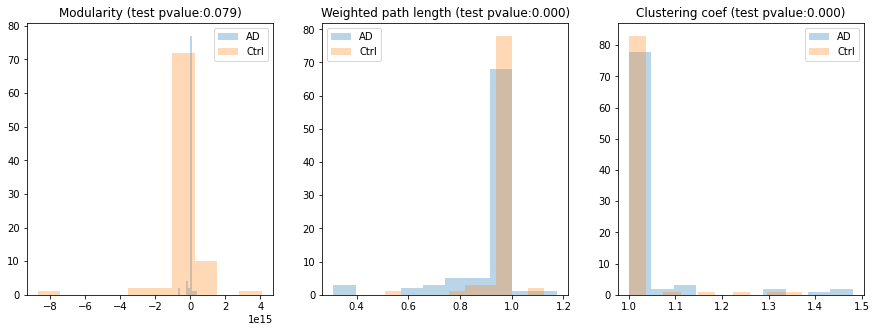

In [25]:
plt.figure(figsize=[15, 5])
for ix, cur_f in enumerate(["tQ", "tmL", "tmC"]):
    cur_fs_AD = np.array([topk_mean(1, graphic_f, dwell, cur_f)[0] 
                 for graphic_f, dwell in zip(graphic_fs_AD, dwellsAD)])
    cur_fs_Ctrl = np.array([topk_mean(1, graphic_f, dwell, cur_f)[0] 
                   for graphic_f, dwell in zip(graphic_fs_Ctrl, dwellsCtrl)])
    #test_res = scipy.stats.ttest_ind(cur_fs_AD, cur_fs_Ctrl, equal_var=False)
    print(np.mean(cur_fs_AD), np.mean(cur_fs_Ctrl))
    test_res = scipy.stats.ranksums(cur_fs_AD, cur_fs_Ctrl)

    plt.subplot(1, 3, ix+1)
    plt.title(f"{fs_name[ix]} (test pvalue:{test_res.pvalue:.3f})")
    plt.hist(cur_fs_AD, label="AD", alpha=0.3)
    plt.hist(cur_fs_Ctrl, label="Ctrl", alpha=0.3)
    plt.legend()

-677360612569.8966 108254117285988.5
0.9283729780635975 0.9672125331774727
1.035582293733745 1.0221450921171182


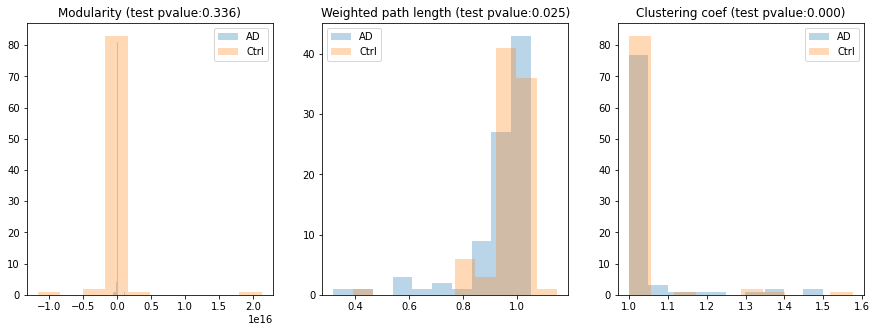

In [26]:
topk = 5
plt.figure(figsize=[15, 5])
for ix, cur_f in enumerate(["tQ", "tmL", "tmC"]):
    cur_fs_AD = np.array([topk_mean(topk, graphic_f, dwell, cur_f)[0] 
                 for graphic_f, dwell in zip(graphic_fs_AD, dwellsAD)])
    cur_fs_Ctrl = np.array([topk_mean(topk, graphic_f, dwell, cur_f)[0] 
                   for graphic_f, dwell in zip(graphic_fs_Ctrl, dwellsCtrl)])
    print(np.mean(cur_fs_AD), np.mean(cur_fs_Ctrl))
    #test_res = scipy.stats.ttest_ind(cur_fs_AD, cur_fs_Ctrl, equal_var=False)
    test_res = scipy.stats.ranksums(cur_fs_AD, cur_fs_Ctrl)

    plt.subplot(1, 3, ix+1)
    plt.title(f"{fs_name[ix]} (test pvalue:{test_res.pvalue:.3f})")
    plt.hist(cur_fs_AD, label="AD", alpha=0.3)
    plt.hist(cur_fs_Ctrl, label="Ctrl", alpha=0.3)
    plt.legend()

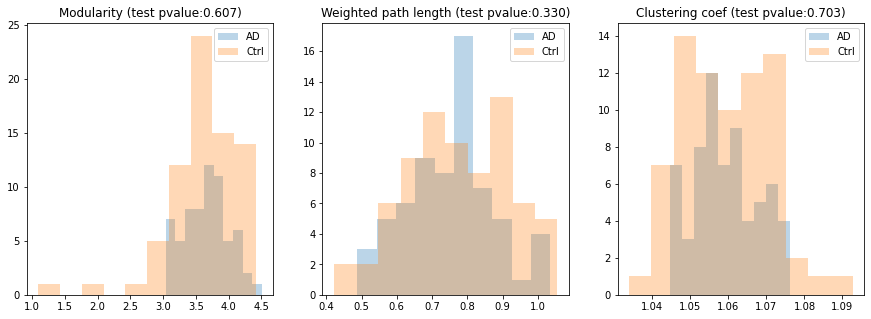

In [50]:
topk = 3
plt.figure(figsize=[15, 5])
for ix, cur_f in enumerate(["tQ", "tmL", "tmC"]):
    cur_fs_AD = [exclude_top1_mean(topk, graphic_f, dwell, cur_f)[0] 
                 for graphic_f, dwell in zip(graphic_fs_AD, dwellsAD) 
                 if len(dwell)>=2]
    cur_fs_Ctrl = [exclude_top1_mean(topk, graphic_f, dwell, cur_f)[0] 
                   for graphic_f, dwell in zip(graphic_fs_Ctrl, dwellsCtrl) 
                   if len(dwell)>= 2]
    #test_res = scipy.stats.ttest_ind(cur_fs_AD, cur_fs_Ctrl, equal_var=False)
    test_res = scipy.stats.ranksums(cur_fs_AD, cur_fs_Ctrl)

    plt.subplot(1, 3, ix+1)
    plt.title(f"{fs_name[ix]} (test pvalue:{test_res.pvalue:.3f})")
    plt.hist(cur_fs_AD, label="AD", alpha=0.3)
    plt.hist(cur_fs_Ctrl, label="Ctrl", alpha=0.3)
    plt.legend()